# CH413 Computational Workshop 3: 
# Predicting the stability of an oxygen-covered diamond(110) surface

**ATTENTION** This notebook contains our class workshop (Parts 1 and 2) **AND** the homework assignment (Part 3).

This notebook has 3 parts.
* Part 1: Calculating the adsorption energy of oxygen on diamond(110): 
* Part 2: Calculating stability phase diagrams for different oxygen-covered diamond phases 
* Part 3: Homework Assignment

The assessment contains a number of tasks, which are very similar to the workshop. You need to answer them in order to pass this part of the course. You have until **January 10th 2020 12pm** to complete this assessment, but **do not leave it to the last minute** Some of the DFT calculations that are required are very slow, so this will take some time. You should aim to finish the notebook in one go (approximately 1 day of work).

To save existing calculations, you can assign variables to the numbers you've already calculated. This way you don't have to recalculate everything if you take breaks.


### IMPORTANT - how to use this notebook
* Use this notebook directly - **you do not need to make a copy first**!
* Write your answers in the designated markup boxes after the ``# YOUR ANSWER`` line
* You can create new code boxes, but discussion comments need to be written in the designated comment cells
* The notebook should not raise any errors, otherwise you won't be able to submit it.

### For further instructions on the assignment, see Part 3

<b>If you have any issues, contact Reinhard J. Maurer (r.maurer@warwick.ac.uk)</b>

## Introduction

<p>In this workshop, we will be exploring Density Functional Theory (DFT) calculations and their application in surface chemistry. We will do this using the ASE and GPAW packages (Click on images to go to webpages):</p>

<div style="display: flex;">
  <div style="flex: 40%;padding: 15px;">
    <a href="https://wiki.fysik.dtu.dk/ase/"><img src="./DFT_MM_MAURER/ase.png" width="80%"></a>
  </div>
  <div style="flex: 40%;padding: 15px;">
     <a href="https://wiki.fysik.dtu.dk/gpaw/"><img src="./DFT_MM_MAURER/gpaw.png" width="100%"></a>
  </div>
</div>


<br> 

### ASE
<b>ASE</b> is a Python package that provides simple workflows for computational chemistry and materials modeling tasks and interfaces with many different DFT software packages. ASE uses Python computer language to define what atoms and molecules are. It defines representations for molecules and materials, allows us to create, visualise, and manipulate them.

For example, we can define an oxygen molecule in ASE and visualise it inside this Jupyter notebook:

In [68]:
from ase import Atoms
from ase.visualize import view

#We define a so-called Atoms object ("collection of atoms") with the chemical formula o2
o2 = Atoms('O2', 
          positions = [
              [0,0,0],   #x,y,z positions of 1st oxygen atom
              [0,0,1.0], #x,y,z positions of 2nd oxygen atom at distance 1 Angstrom from 1st atom, molecule oriented in z direction
          ],
          )

#visualise o2
#OPTION 1
#If you don't put the viewer='x3d' option, it doesn't work.
view(o2, viewer='x3d')
#AFter executing this cell, you can interact with the viewer, rotate the molecule etc.

In [69]:
#There is a much nicer way to visualize molecules, with imolecule and openbabel
#OPTION 2, We will use this option below, so be sure to always import these packages
import imolecule
from imolecule.atoms_to_pybel import atoms_to_pybel as a2p
from openbabel import pybel
pybel.ipython_3d = True

#We just pass the o2 object to this visualisation function
a2p(o2)

#Here are some additional options if you want more control over visualization style
#o2_pybel = a2p(o2)
#shaders = ['toon', 'basic', 'phong', 'lambert']
#drawing_types = ['ball and stick', 'wireframe', 'space filling']
#imolecule.draw(o2_pybel,format="pybel", shader=shaders[3], drawing_type=drawing_types[0])

We can use ASE to generate surface slab structures. Please take a look at this short ASE tutorial on <a href="https://wiki.fysik.dtu.dk/ase/tutorials/surface.html">Nitrogen on Cu(111) </a>

**TASK** After going through the tutorial, pick the relevant commands to generate the N$_2$ on Cu(111) surface and paste them into the following cell (don't forget the import commands) and visualise the structure (use the same command as above).

In [70]:
# ##Use this code cell to create and visualise the N2 on Cu(111) system
# from ase.build import fcc111, add_adsorbate

# ## INSERT HERE
# from ase import Atoms
# from ase.calculators.emt import EMT
# from ase.constraints import FixAtoms
# from ase.optimize import QuasiNewton
# from ase.build import fcc111, add_adsorbate

# h = 1.85
# d = 1.10

# slab = fcc111('Cu', size=(4, 4, 2), vacuum=10.0)

# molecule = Atoms('2N', positions=[(0., 0., 0.), (0., 0., d)])
# add_adsorbate(slab, molecule, h, 'ontop')
# constraint = FixAtoms(mask=[a.symbol != 'N' for a in slab])
# slab.set_constraint(constraint)

# ####
# #view(slab,viewer="x3d")
# import imolecule
# from imolecule.atoms_to_pybel import atoms_to_pybel as a2p
# from openbabel import pybel
# pybel.ipython_3d = True
# a2p(slab)

# #If you have correctly inserted statements from the ASE tutorial,
# #you should be able to see the surface, the molecule, and the edge of the unit cell

### GPAW

One of the software packages that can be interfaced with ASE is <b>GPAW</b> (an abbreviation for "Grid-based Projector-Augmented-Waves", which is the basis set that GPAW uses). It is a Python/C++-based DFT code. GPAW describes the Kohn-Sham DFT wave functions with a basis set that splits the core electrons and the valence electrons. Core electrons are "frozen" and described with projector-augmented waves (PAWs) - a formalism that is closely related to the pseudopotentials we discussed in the lecture. The valence electron states are described with a basis set. That basis set in GPAW is usually a uniform real-space grid. Each grid point is a "basis function". You can read more about this <a href="https://wiki.fysik.dtu.dk/gpaw/algorithms.html">here</a>.

GPAW defines a so-called "*calculator*" - a DFT engine that provides energies and forces to the "*atoms*" object. 
ASE and GPAW are linked by providing a GPAW calculator to the ASE atoms object.
<br>
Let's use GPAW to calculate the properties of the oxygen molecule:

In [71]:
from ase import Atoms
from ase.io import write
from gpaw import GPAW

#Let's use the o2 molecule we set up before
#REMEMBER: If you restart from somewhere in the middle you need to first execute cells above that contain 
#import statements or previous code that is required, e.g. o2 needs to be defined at this point

print(o2) # This just shows that 'o2' is an Atoms object

Atoms(symbols='O2', pbc=False)


**ATTENTION**
The print function shows that the o2 molecule currently doesn't have any periodic boundary conditions defined (pbc=False). We can not define a grid or plane-wave basis without periodic boundary conditions, because we need Born-von-Karman conditions and an infinite lattice (see Lecture 4). That means we first need to put the oxygen molecule in a big box (a so-called supercell).

In [72]:
# #Let's take the o2 molecule and put it into a box
# #We simply "give" the molecule a unit cell defined by three lattice vectors a1, a2, a3

# a = 6.0
# cell = [
#     [a,0,0], #a1
#     [0,a,0], #a2
#     [0,0,a], #a3
# ]
# o2 = Atoms('O2', 
#           positions = [
#               [0,0,0],   #x,y,z positions of 1st oxygen atom
#               [0,0,1.0], #x,y,z positions of 2nd oxygen atom at distance 1 Angstrom from 1st atom, molecule oriented in z direction
#           ],
#           )

# #This is a cubic box with 6 Angstrom side length in all directions
# o2.set_cell(cell) #pass the cell to the o2 atoms object
# #Now we set the periodic boundary conditions to True in all three directions and we center the molecule in the cell
# o2.set_pbc([True,True,True])
# o2.center()
# print(o2)
# #view(o2,viewer='x3d')

# #When we visualize o2, we can now see a box around it
# a2p(o2)

Atoms(symbols='O2', pbc=True, cell=[6.0, 6.0, 6.0])


In [73]:
#Let's set up a GPAW calculator. Here we need to choose numerical settings as discussed in the lecture.
calc_o2 = GPAW(h=0.25, # basis set defined by a grid spacing in Angstrom
            xc="PBE", #choice of exchange-correlation functional
            kpts=(1,1,1), #k-grid sampling: here we only pick a single K point (the Gamma point)
            #because we want to describe oxygen as a single molecule
           )

#h value: The grid spacing defines the basis set. We chose a grid spacing of 0.25 Angstrom in all directions. 
#The smaller the number, the finer the grid and the better the basis set is converged, 
#but also the more computationally costly the calculation becomes.

#Now we "pass" the calculator to the atoms o2 molecule
o2.set_calculator(calc_o2)

#Now we calculate the total energy for o2 using the GPAW calculator with the chosen settings
etot_o2 = o2.get_potential_energy()
print("etot", etot_o2)
#When running this cell, you should see a pop-up of the output file, where you can follow the calculation.


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem123.csc.warwick.ac.uk
Date:   Thu Dec 26 17:33:21 2019
Arch:   x86_64
Pid:    298903
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.25
  kpts: [1 1 1]
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

O-setup:
  name: Oxygen
  id: 32ecd46bf208036f09c70b0ec9a88b78
  Z: 8
  valence: 6
  core: 2
  charge: 0.0
  file: /opt/gpaw-setups/O.PBE.gz
  compensation charges: gauss, rc=0.21, lmax=2
  cuto

**TASK**
Carefully study the output that was generated by this DFT calculation.
Look for following things:
* A basic description of all settings and the geometry
* The actual DFT calculation, where the Kohn-Sham (KS) equations are solved iteratively with many self-consistent field (SCF) iteration steps
* The final total energy (in eV) and the energies and occupation numbers of the Kohn-Sham states

After this, we can now also optimise the bond distance of the O$_2$ molecule:

In [74]:
#we import a geometry optimisation algorithm
from ase.optimize import BFGS
#we apply it to the o2 molecule object (which contains the GPAW calculator)
dyn = BFGS(o2,trajectory='o2_opt.traj')
#we run the optimisation, but before that, we pipe the GPAW text output into a file, so we're not overwhelmed by the output
calc_o2.set(txt="o2_gpaw.txt")
dyn.run(fmax=0.05)
#It might take a while before the steps appear...

Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                         0.860     0.000   0.0% |
 Atomic:                             0.105     0.001   0.0% |
  XC Correction:                     0.105     0.105   0.0% |
 Calculate atomic Hamiltonians:      0.002     0.002   0.0% |
 Communicate:                        0.000     0.000   0.0% |
 Hartree integrate/restrict:         0.010     0.010   0.0% |
 Initialize Hamiltonian:             0.002     0.002   0.0% |
 Poisson:                            0.094     0.011   0.0% |
  Communicate bwd 0:                 0.013     0.013   0.0% |
  Communicate bwd 1:                 0.010     0.010   0.0% |
  Communicate fwd 0:                 0.007     0.007   0.0% |
  Communicate fwd 1:                 0.011     0.011   0.0% |
  fft:                               0.002     0.002   0.0% |
  fft2:                              0.041     0.041   0.0% |
 XC 3D grid:       

True

In each step of the geometry optimisation, the algorithm calculates the energy and forces from DFT and changes the geometry towards lower energy. This is repeated until the maximum force acting on the atoms is reduced to below the threshold value 0.05 eV/Angstrom. Let's check out the optimised bond distance:

In [75]:
print('bond distance in Angstrom', o2.get_distance(0,1))
etot_o2 = o2.get_potential_energy() # let's update the new optimised o2 energy
print('etot_o2', etot_o2)

bond distance in Angstrom 1.2125692492418052
etot_o2 -10.501810507830458


Alright, so much for the basics. Let's get into the meat of things.
This notebook has three parts:
* <b>Part 1</b>: Calculating the adsorption energy of oxygen on diamond(110) with DFT
* <b>Part 2</b>: Calculating stability phase diagrams for oxygen-covered diamond phases
* <b>Part 3</b>: Assessed part of the Workshop with work to do on your own


## Part 1: Calculating the adsorption energy of oxygen on diamond(110): 

Diamond, beyond being shiny and expensive in some of its variants, is an interesting material in chemistry and physics. Particularly for electrochemical applications, boron-doped diamond can be used as a versatile electrode material. Despite the decades of research work that exist on diamond and its bulk and surface properties, many details are not fully understood. For example the diamond(110) surface termination is known to be oxygen-terminated, but the nature of this termination is not fully clear. 
The following picture, shows some examples of possible oxygen functional groups that can sit on the carbon ridges that are exposed at the diamond(110) surface:

<img src="./DFT_MM_MAURER/diamond.png" width="100%">
Reference: Mackey et al., J. Phys. Chem. B 2001, 105, 3803-3812

To resolve this, we need to model different possible surface terminations of diamond surfaces and study, which are the energetically most favorable ones. Let's start by taking a look at a clean diamond(110) surface.


In [76]:
# from ase.io import read
# from ase.visualize import view

# #The folder DFT_MM_MAURER/structures contains several different structure files
# clean_diamond = read('DFT_MM_MAURER/structures/clean_bdd.in')
# #the file contains a minimal surface unit cell of diamond(110) with 7 layers of carbon atoms

# view(clean_diamond, viewer="x3d")
# a2p(clean_diamond)

# #We can visualise the surface better by repeating it periodically in x and y direction
# #COMMENT OUT THE NEXT LINE

# a2p(clean_diamond*[5,5,1])

The adsorption energy per oxygen atom is defined as
$$ E_{\mathrm{ads}}=-\frac{1}{N_O}\left( E^{\mathrm{slab}}_{\mathrm{surf}}(N_O,N_M)-\left( E^{\mathrm{clean}}_{\mathrm{surf}}(0,N_M) + \frac{N_O}{2}E^{\mathrm{total}}_{O_2}  \right)  \right) $$

That means we need to calculate the energy of the isolated oxygen molecule, the clean diamond surface, and the oxygen-covered diamond surface. We already calculated the oxygen molecule, let's calculate the clean diamond surface energy.

In [77]:
# #Let's set up a new calculator for the clean surface
# calc_clean = GPAW(h=0.25, #basis grid spacing
#              xc="PBE", 
#              kpts=(2,2,1), #a 2x2x1 Monkhorst-Pack grid. 2 k points in a1 and 2 k points in a2 direction
#                   #we dont need to do k sampling perpendicular to the surface, as we want this to be the 
#                   #'non-periodic' surface direction
#            )

# clean_diamond.set_calculator(calc_clean)
# etot_clean = clean_diamond.get_potential_energy()
# print('etot_clean', etot_clean)
# #dont be surprised if the calculation takes a little bit. You can follow the convergence in the output window


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem123.csc.warwick.ac.uk
Date:   Thu Dec 26 17:33:57 2019
Arch:   x86_64
Pid:    298903
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.25
  kpts: [2 2 1]
  xc: PBE

Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                         0.926     0.000   0.0% |
 Atomic:                             0.453     0.001   0.0% |
  XC Correction:                     0.452     0.452   

... initialized

Initializing position-dependent things.

Density initialized from atomic densities
Creating initial wave functions:
  28 bands from LCAO basis set

   .-----.  
  /|     |  
 * |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 | |     |  
 |C| C   |  
 | |     |  
 C CC    |  
 | | C   |  
 | |     |  
 C C C   |  
 | | C   |  
 | |     |  
 | .-----.  
 |/     /   
 *-----*    

Positions:
   0 C      0.000003    2.696659    2.536387    ( 0.0000,  0.0000,  0.0000)
   1 C      1.262972    0.910794    3.788912    ( 0.0000,  0.0000,  0.0000)
   2 C      1.262972    1.810287    2.536387    ( 0.0000,  0.0000,  0.0000)
   3 C      0.000003    0.023933    3.788912    ( 0.0000,  0.0000,  0.0000)
   4 C      0.000003    2.696659    5.041437    ( 0.0000,  0.0000,  0.0000)
   5 C      1.262972    0.879127    6.333883    ( 0.0000,  0.0000,  0.0000)
   6 C      1.262972    1.810287    5.0414

Alright, now let's check out one of the oxygen-covered phases shown in the above figure. Let's start with a keto group. You'll find different preoptimised diamond structures in the folder DFT_MM_MAURER/structures/:

In [78]:
# diamond_ketone = read('DFT_MM_MAURER/structures/phase1.in')
# a2p(diamond_ketone*[5,5,1])


In [79]:
# #Let's set up a new calculator for the keto phase slab
# calc = GPAW(h=0.25, 
#              xc="PBE", 
#              kpts=(2,2,1), 
#            )

# diamond_ketone.set_calculator(calc)
# etot_keto = diamond_ketone.get_potential_energy()
# print('etot_keto', etot_keto)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem123.csc.warwick.ac.uk
Date:   Thu Dec 26 17:34:30 2019
Arch:   x86_64
Pid:    298903
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.25
  kpts: [2 2 1]
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

C-setup:
  name: Carbon
  id: 4aa54d4b901d75f77cc0ea3eec22967b
  Z: 6
  valence: 4
  core: 2
  charge: 0.0
  file: /opt/gpaw-setups/C.PBE.gz
  compensation charges: gauss, rc=0.20, lmax=2
  cuto

etot_keto -94.01840563430821


Now we can calculate the adsorption energy as defined by the equation above:

In [80]:
# e_ads = -(etot_keto -(etot_clean+etot_o2/2) )
# print ("e_ads", e_ads)

e_ads 1.4136394211303127


The adsorption energy of this oxygen atom is about 1.41 eV per oxygen atom. We can also calculate this as adsorption energy per surface area by dividing by the surface area of the unit cell:

In [81]:
# #The surface area of the unit cell is defined as the absolute value of the cross product between the a1 and a2 lattice vectors
# cell = diamond_ketone.get_cell()
# print(cell)
# a, b, c = cell
# #let's use the linear algebra operations in numpy for this
# import numpy as np
# area = np.linalg.norm(np.cross(a,b))
# print('area', area)
# #In this simple rectangular unit cell case, it would also have been enough to multiply 2.52 with 3.57
# print('area', a[0]*b[1])

# #The adsorption energy per surface area and oxygen atom is:
# print('e_ads per area', e_ads/area)

Cell([2.52594, 3.5722179, 18.10376])
area 9.023208082325999
area 9.023208082325999
e_ads per area 0.1566670532511875


## Part 2: Calculating stability phase diagrams for different oxygen-covered diamond phases

Now that we have an adsorption energy, we can actually plot this as a function of chemical potential just as we discussed it in the lecture. Just as a reminder, here's the equation we use for that:

$$ Δ𝐺^{\mathrm{𝑎𝑑}} (Δ\mu_𝑂)≈\frac{𝑁_𝑂}{𝐴} 𝐸_{\mathrm{ads}}+(𝑁_𝑀−𝑁_𝑀^′ ) 𝐸_M^{bulk}+\frac{𝑁_𝑂}{𝐴} Δ\mu_𝑂 (𝑇,𝑝) $$

Let's plot this in a graph of $$ Δ𝐺^{\mathrm{𝑎𝑑}} vs. Δ\mu_𝑂 $$


We already have calculated the adsorption energy per surface area and oxygen atom:

In [82]:
# print('e_ads per area', e_ads/area, 'eV/Angstrom')
# e_b = e_ads/area


e_ads per area 0.1566670532511875 eV/Angstrom


The adsorption free energy is a straight line with the y-intercept defined by the adsorption energy per surface area and oxygen atom and the gradient defined by $N_O/A$:

In [83]:
# gradient = 1.0/area #1 oxygen atom per surface area
# print('gradient', gradient, '1/Angstrom')

gradient 0.11082532851688602 1/Angstrom


Let's generate that phase diagram. Here, we need to use the above equation to generate adsorption free energy values at certain values of chemical potential:

<IPython.core.display.Javascript object>


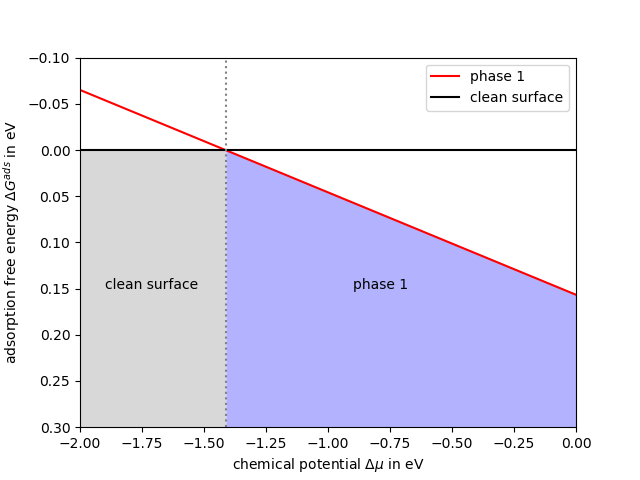

In [84]:
# import matplotlib.pyplot as plt
# %matplotlib notebook 
# #this gives us an interactive graph with a cross hair

# mu = np.arange(-2.50,0.1,0.1) # This generates mu values for the x-axis from -2.5 to 0 with a spacing of 0.01 eV

# #let's generate the y value for our plot for a given set of mu values
# #This is a very Pythonic ("integrated and neat") way to do that
# Gads = [ e_b+x*gradient for x in mu ] #We loop over all mu values (calling each value x) and calculate the G_ads value via the above equation

# ################################################
# #PLOTTING ROUTINES

# plt.plot(mu,Gads, color='red',label='phase 1') #plot my vs. Gads

# #we should also plot the line for the clean surface, which is a straight horizontal line at 0
# plt.plot(mu, [0 for m in mu], color='black', label='clean surface')


# #lets not forget that we want these plots to have inverted y axis, 
# #because a bigger value means a more stable phase
# plt.ylim(0.30, -0.10) #from bigger to smaller value
# plt.xlim(-2.0,0)
# plt.xlabel(r'chemical potential $\Delta\mu$ in eV') 
# #by the way, this is how you get latex math into the label, dont forget the r in front
# plt.ylabel(r'adsorption free energy $\Delta G^{ads}$ in eV')
# plt.legend()
# plt.text(-1.90, 0.15,'clean surface') #add text to the graph
# plt.text(-0.90, 0.15,'phase 1')

# #fancy area filling
# plt.fill([-4.0,-1.41, -1.41, -4.0],[0.0,0.0, 0.40, 0.40],'gray', alpha=0.3) # let's fill the surface area for the clean surface
# plt.fill([-1.41,-1.41,0.0,0.0],[0.40,0.0, 0.15616,0.40],'b', alpha=0.3) #let's fill the surface area for phase 1 with a 

# plt.axvline(-1.41,color='gray',ls=':') #This is a vertical line to mark the intersection between the two phases

We can see that the two curves cross at about -1.41 eV chemical potential. This is the point where the keto-terminated oxygenated diamond(110) surface becomes more stable than the clean diamond(110) surface.

Of course, we should also try to find out which other phases exist and how stable they are. This is going to be your job for the assessement in Part 3.


## Part 3: Assessed part of the Workshop

## TASK 1: Convergence testing


As discussed in the lecture, we should check the convergence of this adsorption energy by varying the basis set cutoff (the grid spacing h) and by varying the k-grid.

1. Recalculate the energy of molecular gasphase oxygen, the clean surface, and the keto phase with different settings to study the convergence of the adsorption energy, first with basis set, and then with k-point.
    * Vary the basis grid spacing between [0.25,0.20,0.15,0.10], Note: stick with 2x2x1 k-grid for the surfaces and a 1x1x1 grid for o2
    * Vary the k-grid between [(1,1,1), (2,2,1), (3,3,1), (4,4,1)], Note: don't vary it for the o2 molecule, stick with 1x1x1
    
    If you think it is necessary, you should also explore points inbetween these settings
    
2. Generate two plots of
$E_{ads}$ vs. basis (0.25,0.20,0.15,0.12) and $E_{ads}$ vs. k point (1,2,3,4)

    Below you'll find some prepared functions that help you to plot the results. Pleae correctly label the axes.
3. Discuss the convergence behavior and discuss in detail if any of the chosen settings would be numerically precise enough to predict the adsorption energy of different oxygen-diamond phases up to a precision of $\pm$0.10 eV. (Note: Discuss the precision, not the method accuracy.)

**Attention** Some of the calculations with higher settings may run a few minutes and require a bit of patience

You can add as many cells as you think you'll need, but please fill in your discussion in the labeled comments cell

In [1]:
# from ase import Atoms
# from ase.visualize import view
# from ase.io import read
# from gpaw import GPAW
# from imolecule.atoms_to_pybel import atoms_to_pybel as a2p
# from openbabel import pybel
# pybel.ipython_3d = True

# a = 6.0
# cell = [
#     [a,0,0], #a1
#     [0,a,0], #a2
#     [0,0,a], #a3
# ]
# o2 = Atoms('O2', 
#           positions = [
#               [0,0,0],   
#               [0,0,1.0], 
#           ],
#           )

# o2.set_cell(cell)
# o2.set_pbc([True,True,True])
# o2.center()
# a2p(o2)

# calc_o2= GPAW(h=0.25,
#               xc="PBE",
#               kpts=(1,1,1),
#              )

# from ase.optimize import BFGS
# dyn = BFGS(o2,trajectory='o2_opt.traj')
# calc_o2.set(txt="o2_gpaw.txt")
# o2.set_calculator(calc_o2)
# dyn.run(fmax=0.05)



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem124.csc.warwick.ac.uk
Date:   Sat Dec 28 16:56:12 2019
Arch:   x86_64
Pid:    179878
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.25
  kpts: [1 1 1]
  xc: PBE

      Step     Time          Energy         fmax
BFGS:    0 16:56:20       -7.640226       35.1831
BFGS:    1 16:56:26       -9.609731       16.1047
BFGS:    2 16:56:30      -10.327452        5.8758
BFGS:    3 16:56:36      -10.475958        1.9987
BFGS:    4 16:56:42      -10.500293        

True

In [2]:
# clean_diamond = read('DFT_MM_MAURER/structures/clean_bdd.in')
# a2p(clean_diamond*[5,5,1])

In [3]:
# diamond_ketone = read('DFT_MM_MAURER/structures/phase1.in')
# a2p(diamond_ketone*[5,5,1])

In [4]:
# basis = [0.25,0.22,0.20,0.17,0.15,0.12,0.10] # feel free to also explore points inbetween
# e_ads_list = []

# for b in basis:
#     calc_o2 = GPAW(h=b, 
#             xc="PBE", 
#             kpts=(1,1,1), 
#            )
    
#     o2.set_calculator(calc_o2)

#     etot_o2 = o2.get_potential_energy()
#     print("etot", etot_o2)

#     calc_clean = GPAW(h=b, 
#              xc="PBE", 
#              kpts=(2,2,1), 
#            )

#     clean_diamond.set_calculator(calc_clean)
#     etot_clean = clean_diamond.get_potential_energy()
#     print('etot_clean', etot_clean)
    
#     calc = GPAW(h=b, 
#              xc="PBE", 
#              kpts=(2,2,1), 
#            )

#     diamond_ketone.set_calculator(calc)
#     etot_keto = diamond_ketone.get_potential_energy()
#     print('etot_keto', etot_keto)
    
#     e_ads = -(etot_keto -(etot_clean+etot_o2/2) )
#     e_ads_list.append(e_ads)

    


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem124.csc.warwick.ac.uk
Date:   Sat Dec 28 16:56:48 2019
Arch:   x86_64
Pid:    179878
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.25
  kpts: [1 1 1]
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

O-setup:
  name: Oxygen
  id: 32ecd46bf208036f09c70b0ec9a88b78
  Z: 8
  valence: 6
  core: 2
  charge: 0.0
  file: /opt/gpaw-setups/O.PBE.gz
  compensation charges: gauss, rc=0.21, lmax=2
  cuto

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 12*16*72 grid


Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 12*16*72 grid


Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 16

  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 0  1  0)  ( 0  1  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 1  0  0)  ( 1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)
  (-1  0  0)  (-1  0  0)  ( 1  0  0)  ( 1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  (-1  0  0)  (-1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 12*16*84 grid


Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 12*16*84 grid


Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 16

  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 0  1  0)  ( 0  1  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 1  0  0)  ( 1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)
  (-1  0  0)  (-1  0  0)  ( 1  0  0)  ( 1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  (-1  0  0)  (-1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 12*16*92 grid


Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 12*16*92 grid


Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 16

  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 0  1  0)  ( 0  1  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 1  0  0)  ( 1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)
  (-1  0  0)  (-1  0  0)  ( 1  0  0)  ( 1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  (-1  0  0)  (-1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 16*20*108 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 16*20*108 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 16

  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 0  1  0)  ( 0  1  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 1  0  0)  ( 1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)
  (-1  0  0)  (-1  0  0)  ( 1  0  0)  ( 1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  (-1  0  0)  (-1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 16*24*120 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 16*24*120 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 16

  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 0  1  0)  ( 0  1  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 1  0  0)  ( 1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)
  (-1  0  0)  (-1  0  0)  ( 1  0  0)  ( 1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  (-1  0  0)  (-1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 20*28*152 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 20*28*152 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 16

  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 1  0  0)  ( 0  1  0)  ( 0  1  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 1  0  0)  ( 1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)  ( 0 -1  0)
  (-1  0  0)  (-1  0  0)  ( 1  0  0)  ( 1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

  (-1  0  0)  (-1  0  0)  (-1  0  0)  (-1  0  0)
  ( 0  1  0)  ( 0  1  0)  ( 0 -1  0)  ( 0 -1  0)
  ( 0  0  1)  ( 0  0 -1)  ( 0  0  1)  ( 0  0 -1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 24*36*180 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 24*36*180 grid

In [27]:
# print(e_ads_list)

[1.4136394245144004, 1.5528003488757776, 1.5222500384948603, 1.6358372214324675, 1.6391402073427912, 1.6412119318386402, 1.637328297409283]


<IPython.core.display.Javascript object>


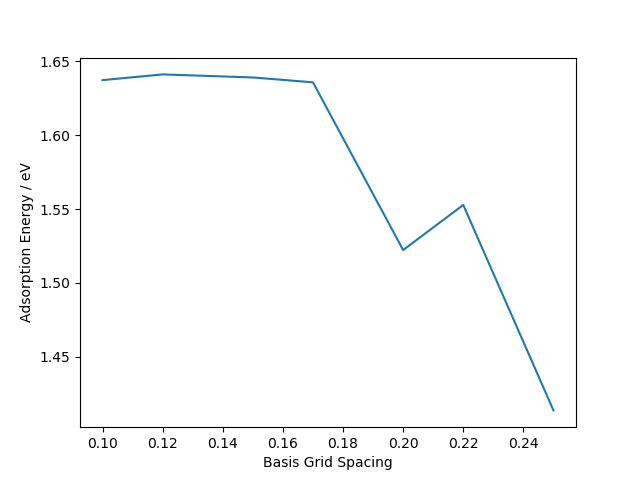

In [9]:
# ####Basis Convergence Plotting#####
# import numpy as np

# from matplotlib import pyplot as plt
# %matplotlib notebook 

# xdata = basis
# ydata = e_ads_list
# plt.xlabel('Basis Grid Spacing')
# plt.ylabel('Adsorption Energy / eV')
# plt.plot(xdata,ydata)



In [6]:
# #k grid

# calc_o2 = GPAW(h=0.12, 
#             xc="PBE", 
#             kpts=(1,1,1), 
#            )
    
# o2.set_calculator(calc_o2)

# etot_o2 = o2.get_potential_energy()
# print("etot", etot_o2)

# ks = [1,2,3,4] 
# e_ads_list_k = []

# for k in ks:
#     calc_clean = GPAW(h=0.12, 
#              xc="PBE", 
#              kpts=(k,k,1),
#            )

#     clean_diamond.set_calculator(calc_clean)
#     etot_clean = clean_diamond.get_potential_energy()
#     print('etot_clean', etot_clean)

#     calc = GPAW(h=0.12, 
#              xc="PBE", 
#              kpts=(k,k,1), 
#            )

#     diamond_ketone.set_calculator(calc)
#     etot_keto = diamond_ketone.get_potential_energy()
#     print('etot_keto', etot_keto)
    
#     e_ads = -(etot_keto -(etot_clean+etot_o2/2) )
#     e_ads_list_k.append(e_ads)
    


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem124.csc.warwick.ac.uk
Date:   Sat Dec 28 17:17:26 2019
Arch:   x86_64
Pid:    179878
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.12
  kpts: [1 1 1]
  xc: PBE

Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                         1.229     0.000   0.0% |
 Atomic:                             0.102     0.001   0.0% |
  XC Correction:                     0.102     0.102   

... initialized

Initializing position-dependent things.

Density initialized from atomic densities
Creating initial wave functions:
  8 bands from LCAO basis set

     .--------------.  
    /|              |  
   / |              |  
  /  |              |  
 *   |              |  
 |   |    O         |  
 |   |    O         |  
 |   .--------------.  
 |  /              /   
 | /              /    
 |/              /     
 *--------------*      

Positions:
   0 O      3.000000    3.000000    2.393715    ( 0.0000,  0.0000,  0.0000)
   1 O      3.000000    3.000000    3.606285    ( 0.0000,  0.0000,  0.0000)

Unit cell:
           periodic     x           y           z      points  spacing
  1. axis:    yes    6.000000    0.000000    0.000000    52     0.1154
  2. axis:    yes    0.000000    6.000000    0.000000    52     0.1154
  3. axis:    yes    0.000000    0.000000    6.000000    52     0.1154

  Lengths:   6.000000   6.000000   6.000000
  Angles:   90.000000  90.000000  90.000000

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/1

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 20*28*152 grid
  Fine grid: 40*56*304 grid
  Total Charge: 0.000000 

Density mixing:
  Method: separ

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

1 k-point (Gamma)
1 k-point in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/1

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 20*28*152 grid
  Fine grid: 40*56*304 grid
  Total Charge: 0.000000 

Density mixing:
  Method: separ

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 20*28*152 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

4 k-points: 2 x 2 x 1 Monkhorst-Pack grid
2 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.25000000   -0.25000000    0.00000000          2/4
   1:     0.25000000    0.25000000    0.00000000          2/4

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  Wavefunction extrapolation:
    Improved wavefunction reuse through dual PAW basis 

Eigensolver
   Davidson(niter=2, smin=None, normalize=True) 

Densities:
  Coarse grid: 20*28*152 grid

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

9 k-points: 3 x 3 x 1 Monkhorst-Pack grid
5 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/9
   1:     0.00000000    0.33333333    0.00000000          2/9
   2:     0.33333333   -0.33333333    0.00000000          2/9
   3:     0.33333333    0.00000000    0.00000000          2/9
   4:     0.33333333    0.33333333    0.00000000          2/9

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  W

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

9 k-points: 3 x 3 x 1 Monkhorst-Pack grid
5 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/9
   1:     0.00000000    0.33333333    0.00000000          2/9
   2:     0.33333333   -0.33333333    0.00000000          2/9
   3:     0.33333333    0.00000000    0.00000000          2/9
   4:     0.33333333    0.33333333    0.00000000          2/9

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  W

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

16 k-points: 4 x 4 x 1 Monkhorst-Pack grid
8 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.12500000   -0.37500000    0.00000000          2/16
   1:     0.12500000   -0.12500000    0.00000000          2/16
   2:     0.12500000    0.12500000    0.00000000          2/16
   3:     0.12500000    0.37500000    0.00000000          2/16
   4:     0.37500000   -0.37500000    0.00000000          2/16
   5:     0.37500000   -0.12500000    0.00000000          2/16
   6:     0.37500000    0.12500000    0.00000000          2/16
   7:     0.37500000    0.37500000    

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

16 k-points: 4 x 4 x 1 Monkhorst-Pack grid
8 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.12500000   -0.37500000    0.00000000          2/16
   1:     0.12500000   -0.12500000    0.00000000          2/16
   2:     0.12500000    0.12500000    0.00000000          2/16
   3:     0.12500000    0.37500000    0.00000000          2/16
   4:     0.37500000   -0.37500000    0.00000000          2/16
   5:     0.37500000   -0.12500000    0.00000000          2/16
   6:     0.37500000    0.12500000    0.00000000          2/16
   7:     0.37500000    0.37500000    

In [7]:
# print(ks)
# print(e_ads_list_k)

[1, 2, 3, 4]
[-0.6986537250483451, 1.6412119318386402, 1.6846709056110143, 1.6820487216138957]


<IPython.core.display.Javascript object>


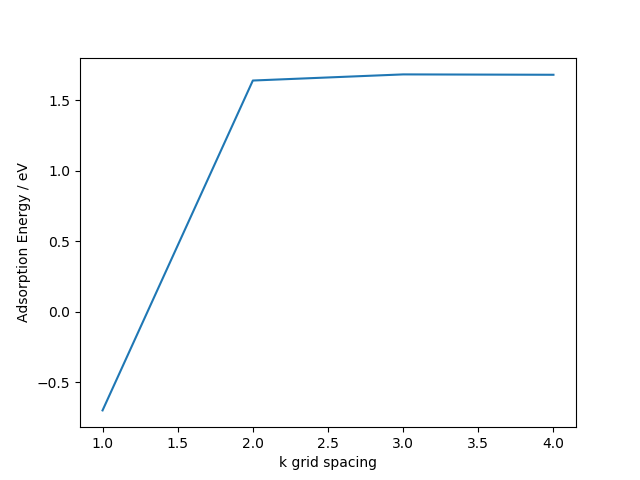

In [10]:
# ####K point Convergence Plotting#####

# ####FILL IN
# import numpy as np

# from matplotlib import pyplot as plt
# %matplotlib notebook 
# xdata = ks
# ydata = e_ads_list_k
# plt.xlabel('k grid spacing')
# plt.ylabel('Adsorption Energy / eV')
# plt.plot(xdata,ydata)





**DISCUSSION OF RESULTS for TASK 1**


Enter discussion text below where it says "YOUR ANSWER" by double clicking. 
Use Markdown and Latex syntax, where necessary. Google 'Markdown cheatsheet'

For the basis grid spacing, I decided to go with the spacing value that gives the greatest adsorption value. (0.12)

For the k grid: 2, 3, 4 all are extremely close to eah other and if higher numbers were computed, they would converge to a single value, for which the values obtained by k grid of 2, 3 and 4 would be within 0.1 eV. To get the maximum accuracy and to not be computationally expensive, k value of 3 is best giving kpts = [3,3,1]

## Task 2: Phase Diagram of various oxygen-covered diamond(110) surfaces

In addition to the structure discussed in Parts 1 and 2, there are many other possible oxygen terminations.

1. Visualise the additional oxygen terminated phases provided in DFT_MM_MAURER and calculate the surface area and number of oxygen-atoms-per-surface-area ratio for each.
   * phase2.in (keto phase with 2 oxygen atoms per unit cell)
   * phase4.in (5-ring ether phase)
   * phase5.in (peroxo phase)

2. Use the settings that you have identified in Task 1 to calculate the adsorption energies for all 4 phases (1,2,4,5)

3. Plot the phase diagram of adsorption free energy ($\Delta G^{ad}$) vs. change in chemical potential ($\Delta\mu_O$). 
   
   **Note**: In all cases, the number of carbon atoms is the same, so the contribution from the change in bulk atoms can be ignored
   
4. Identify the most stable phases for each region of chemical potential. Note and discuss this in a comment cell

5. Translate the phase diagram for a change in chemical potential to a Temperature vs. Pressure phase diagram in the temperature range of 100 K to 1200K and pressure range of 10E-9 atm to 1atm.

   Do this using following expression: 
   $$ \Delta\mu(T,p)= a\cdot T^4+b\cdot T^3+c\cdot T^2+d\cdot T+ e + \frac{1}{2}k_BT\ln{\frac{p}{p^0}}$$
   where $T^0=298.15$ K and $p^0=1$ atm and $a=-4.231\cdot 10^{-12}$ eV/K, $b=6.505\cdot 10^{-9}$ eV/K, $c=-3.401\cdot 10^{-6}$ eV/K, $d=-1.259\cdot 10^{-3}$ eV, $e=-8.883\cdot 10^{-2}$ eV
   
   Below I have written a function that provides you with the chemical potential, given certain values of T [in K] and p [in atm]

6. Discuss all your results in detail and answer following questions:
   * What is the most stable phase at ambient pressure and temperature conditions?
   * What happens when we heat the surface (assuming no kinetic barriers)?
   * What happens when we leave the temperature constant and increase the pressure?
   * In the oxygen on Pd(100) example, we also had a bulk oxide phase involved. What would be the 'bulk oxid' for diamond? Under which conditions would this bulk oxide become relevant?


In [2]:
def deltamu_Tp(T,p):
    """
    takes T in Kelvin and p in atm and converts to Delta mu in eV
    The function is a polynomial fit based on the data provided here:
    https://janaf.nist.gov/tables/O-029.html
    
    Use this function to translate T and P values into delta mu values.
    """
    from math import log
    a = -4.231E-12
    b =  6.505E-09
    c = -3.401E-06
    d = -1.259E-03
    e = -8.883E-02
    kB = 8.6173E-05
    
    mu_Tp0 = a*(T**4)+b*(T**3)+c*(T**2)+d*T+e
    mu_Tp = mu_Tp0 + 0.5*T*kB*log(p) 
    return mu_Tp

#### Example: The value of chemical potential at 600K and standard pressure is 
print(deltamu_Tp(600,1))

-1.2118475999999998


In [16]:
# from ase import Atoms
# from ase.visualize import view
# from ase.io import read
# from gpaw import GPAW
# from imolecule.atoms_to_pybel import atoms_to_pybel as a2p
# from openbabel import pybel
# pybel.ipython_3d = True

# a = 6.0
# cell = [
#     [a,0,0], #a1
#     [0,a,0], #a2
#     [0,0,a], #a3
# ]
# o2 = Atoms('O2', 
#           positions = [
#               [0,0,0],   
#               [0,0,1.0], 
#           ],
#           )

# o2.set_cell(cell)
# o2.set_pbc([True,True,True])
# o2.center()
# a2p(o2)

# calc_o2= GPAW(h=0.12,
#               xc="PBE",
#               kpts=(1,1,1),
#              )

# from ase.optimize import BFGS
# dyn = BFGS(o2,trajectory='o2_opt.traj')
# calc_o2.set(txt="o2_gpaw.txt")
# o2.set_calculator(calc_o2)
# dyn.run(fmax=0.05)

# clean_diamond = read('DFT_MM_MAURER/structures/clean_bdd.in')
# phase1=read('DFT_MM_MAURER/structures/phase1.in')
# phase2=read('DFT_MM_MAURER/structures/phase2.in')
# phase4=read('DFT_MM_MAURER/structures/phase4.in')
# phase5=read('DFT_MM_MAURER/structures/phase5.in')





  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem123.csc.warwick.ac.uk
Date:   Fri Dec 27 18:15:18 2019
Arch:   x86_64
Pid:    243883
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.12
  kpts: [1 1 1]
  xc: PBE

Memory usage: 110.65 MiB
Date: Fri Dec 27 18:15:18 2019
      Step     Time          Energy         fmax
BFGS:    0 18:16:27       -6.400552       36.6303
BFGS:    1 18:17:19       -8.467292       16.8180
BFGS:    2 18:17:50       -9.236005        6.6722
BFGS:    3 18:18:27       -9.429447  

In [17]:
# a2p(phase1*[5,5,1])



In [18]:
# cell = phase1.get_cell()
# print(cell)
# a, b, c = cell
# import numpy as np
# area1 = np.linalg.norm(np.cross(a,b))
# print('area', area1)

# o2_per_area1 = 1/area1
# print("Gradient =",o2_per_area1,"1/Angstrom")

Cell([2.52594, 3.5722179, 18.10376])
area 9.023208082325999
Gradient = 0.11082532851688602 1/Angstrom


In [19]:
# a2p(phase2*[5,5,1])


In [20]:
# cell = phase2.get_cell()
# print(cell)
# a, b, c = cell
# import numpy as np
# area2 = np.linalg.norm(np.cross(a,b))
# print('area', area2)

# o2_per_area2 = 2/area2
# print("Gradient =",o2_per_area2,"1/Angstrom")

Cell([2.52594, 3.5722179, 18.10376])
area 9.023208082325999
Gradient = 0.22165065703377204 1/Angstrom


In [21]:
# a2p(phase4*[5,5,1])


In [22]:
# cell = phase4.get_cell()
# print(cell)
# a, b, c = cell
# import numpy as np
# area4 = np.linalg.norm(np.cross(a,b))
# print('area', area4)

# o2_per_area4 = 1/area4
# print("Gradient =",o2_per_area4,"1/Angstrom")

Cell([2.52594, 3.5722179, 18.10376])
area 9.023208082325999
Gradient = 0.11082532851688602 1/Angstrom


In [23]:
# a2p(phase5*[5,5,1])


In [24]:
# cell = phase5.get_cell()
# print(cell)
# a, b, c = cell
# import numpy as np
# area5 = np.linalg.norm(np.cross(a,b))
# print('area', area5)

# o2_per_area5 = 2/area5
# print("Gradient =",o2_per_area5,"1/Angstrom")

Cell([2.52594, 3.5722179, 18.10376])
area 9.023208082325999
Gradient = 0.22165065703377204 1/Angstrom


In [27]:
# #Task 2.2 #Adsorption energy calculations for all phases

# #o2
# calc_o2 = GPAW(h=0.12, 
#             xc="PBE", 
#             kpts=(1,1,1), 
#            )
    
# o2.set_calculator(calc_o2)

# etot_o2 = o2.get_potential_energy()
# print("etot", etot_o2)


# #clean
# calc_clean = GPAW(h=0.12, 
#              xc="PBE", 
#              kpts=(3,3,1),
#            )

# clean_diamond.set_calculator(calc_clean)
# etot_clean = clean_diamond.get_potential_energy()
# print('etot_clean', etot_clean)

# #different phases
# calc = GPAW(h=0.12, 
#              xc="PBE", 
#              kpts=(3,3,1), 
#            )
# #phase1
# phase1.set_calculator(calc)
# etot_phase1 = phase1.get_potential_energy()
# print('etot_phase1', etot_phase1)
    
# e_ads1 = -(etot_phase1 -(etot_clean+etot_o2/2) )/area1

# #phase2
# phase2.set_calculator(calc)
# etot_phase2 = phase2.get_potential_energy()
# print('etot_phase2', etot_phase2)
    
# e_ads2 = -(etot_phase2 -(etot_clean+etot_o2) )/area2

# #phase4
# phase4.set_calculator(calc)
# etot_phase4 = phase4.get_potential_energy()
# print('etot_phase4', etot_phase4)
    
# e_ads4 = -(etot_phase4 -(etot_clean+etot_o2/2) )/area4

# #phase5
# phase5.set_calculator(calc)
# etot_phase5 = phase5.get_potential_energy()
# print('etot_phase5', etot_phase5)
    
# e_ads5 = -(etot_phase5 -(etot_clean+etot_o2) )/area5



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   msujhv@rem123.csc.warwick.ac.uk
Date:   Fri Dec 27 18:26:58 2019
Arch:   x86_64
Pid:    243883
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.18.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.3.1)
libxc:  4.3.4
units:  Angstrom and eV
cores:  1

Input parameters:
  h: 0.12
  kpts: [1 1 1]
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

O-setup:
  name: Oxygen
  id: 32ecd46bf208036f09c70b0ec9a88b78
  Z: 8
  valence: 6
  core: 2
  charge: 0.0
  file: /opt/gpaw-setups/O.PBE.gz
  compensation charges: gauss, rc=0.21, lmax=2
  cuto

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

9 k-points: 3 x 3 x 1 Monkhorst-Pack grid
5 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/9
   1:     0.00000000    0.33333333    0.00000000          2/9
   2:     0.33333333   -0.33333333    0.00000000          2/9
   3:     0.33333333    0.00000000    0.00000000          2/9
   4:     0.33333333    0.33333333    0.00000000          2/9

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  W

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

9 k-points: 3 x 3 x 1 Monkhorst-Pack grid
5 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/9
   1:     0.00000000    0.33333333    0.00000000          2/9
   2:     0.33333333   -0.33333333    0.00000000          2/9
   3:     0.33333333    0.00000000    0.00000000          2/9
   4:     0.33333333    0.33333333    0.00000000          2/9

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  W

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

9 k-points: 3 x 3 x 1 Monkhorst-Pack grid
5 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/9
   1:     0.00000000    0.33333333    0.00000000          2/9
   2:     0.33333333   -0.33333333    0.00000000          2/9
   3:     0.33333333    0.00000000    0.00000000          2/9
   4:     0.33333333    0.33333333    0.00000000          2/9

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  W

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

9 k-points: 3 x 3 x 1 Monkhorst-Pack grid
5 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/9
   1:     0.00000000    0.33333333    0.00000000          2/9
   2:     0.33333333   -0.33333333    0.00000000          2/9
   3:     0.33333333    0.00000000    0.00000000          2/9
   4:     0.33333333    0.33333333    0.00000000          2/9

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  W

Occupation numbers:
  Fermi-Dirac: width=0.1000 eV

Convergence criteria:
  Maximum total energy change: 0.0005 eV / electron
  Maximum integral of absolute density change: 0.0001 electrons
  Maximum integral of absolute eigenstate change: 4e-08 eV^2
  Maximum number of iterations: 333

Symmetries present (total): 1

  ( 1  0  0)
  ( 0  1  0)
  ( 0  0  1)

9 k-points: 3 x 3 x 1 Monkhorst-Pack grid
5 k-points in the irreducible part of the Brillouin zone
       k-points in crystal coordinates                weights
   0:     0.00000000    0.00000000    0.00000000          1/9
   1:     0.00000000    0.33333333    0.00000000          2/9
   2:     0.33333333   -0.33333333    0.00000000          2/9
   3:     0.33333333    0.00000000    0.00000000          2/9
   4:     0.33333333    0.33333333    0.00000000          2/9

Wave functions: Uniform real-space grid
  Kinetic energy operator: 6*3+1=19 point O(h^6) finite-difference Laplacian
  ScaLapack parameters: grid=1x1, blocksize=None
  W

In [28]:
# #collect all adsorption energies, gradients and other values you'll need

# print("intercepts:")
# print(e_ads1)
# print(e_ads2)
# print(e_ads4)
# print(e_ads5)

# print("gradients:")
# print(o2_per_area1)
# print(o2_per_area2)
# print(o2_per_area4)
# print(o2_per_area5)

intercepts:
0.18657094231244126
0.22363705246968776
0.1306246257909149
0.25686936006135774
gradients:
0.11082532851688602
0.22165065703377204
0.11082532851688602
0.22165065703377204


<IPython.core.display.Javascript object>


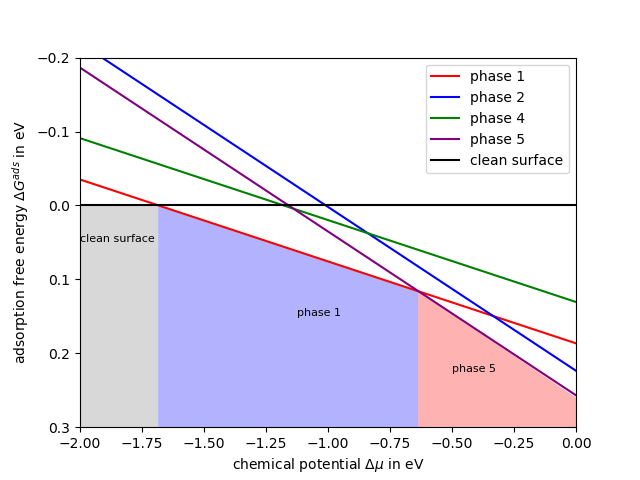

In [61]:
# #Task2.3  ###Phase diagram plot G vs. mu

# import matplotlib.pyplot as plt
# %matplotlib notebook 
# mu = np.arange(-5,1,0.1)
# Gads1 = [ e_ads1+x*o2_per_area1 for x in mu ] 
# Gads2 = [ e_ads2+x*o2_per_area2 for x in mu ]
# Gads4 = [ e_ads4+x*o2_per_area4 for x in mu ]
# Gads5 = [ e_ads5+x*o2_per_area5 for x in mu ]

# plt.plot(mu,Gads1, color='red',label='phase 1') #plot my vs. Gads
# plt.plot(mu,Gads2, color='blue',label='phase 2')
# plt.plot(mu,Gads4, color='green',label='phase 4')
# plt.plot(mu,Gads5, color='purple',label='phase 5')
# plt.plot(mu, [0 for m in mu], color='black', label='clean surface')

# plt.ylim(0.3, -0.2) 
# plt.xlim(-2.0,0)
# plt.xlabel(r'chemical potential $\Delta\mu$ in eV') 
# plt.ylabel(r'adsorption free energy $\Delta G^{ads}$ in eV')
# plt.legend()

# plt.fill([-2.0,-1.685, -1.685, -2.0],[0.0,0.0, 0.40, 0.40],'gray', alpha=0.3) 
# plt.fill([-1.685,-0.636,-0.636,-1.685],[0,0.116,0.3,0.3],'blue', alpha=0.3)
# plt.fill([-0.636,0,0,-0.636],[0.116,0.26,0.3,0.3],'red',alpha=0.3)

# plt.text(-2,0.05,'clean surface',fontsize= 8)
# plt.text(-1.125,0.15,'phase 1', fontsize=8)
# plt.text(-0.5,0.225,'phase 5', fontsize=8)
# plt.savefig('Phase Diagram.png')

**Task 2.4 Identify the most stable phases for each region of chemical potential. Note and discuss this in the next comment cell**

Enter discussion text below where it says "YOUR ANSWER" by double clicking. 

mu range -X.0 - -Y.0 : Phase X is most stable
etc...



From -2.00 to -1.685 eV, the clean diamond surface is the most stable.
From -1.685 to -0.636 eV, the keto terminated phase is the most stable.
From -0.636 to 0 eV, the peroxo terminated phase is the most stable.

PHases 1 and 4 have the same surface density (same gradients), as do 2 and 5. Therefore the stability of each phase is dependent on the adsorption energies (the intercepts) of the phases. The chemical potential can be thought of  as the cost of obtaining an oxygen atom on the surface, hence at more negative potentials the surface remains clean. At higher potentials, more oxygen atoms are added with their orientations described by the stable phases.

<IPython.core.display.Javascript object>


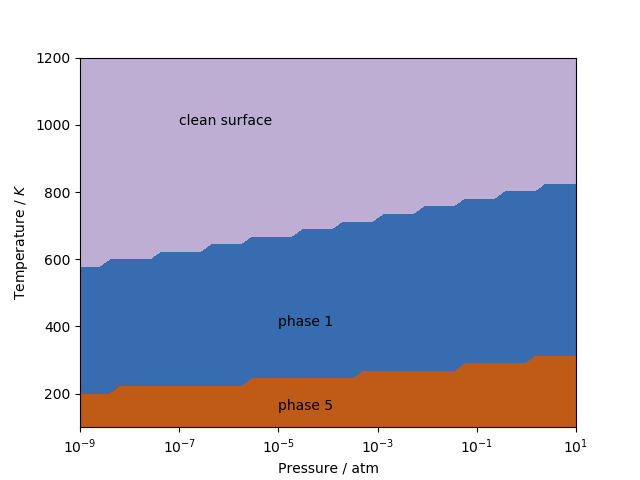

In [62]:
# #Task 2.5 ####Translate phase diagram into T vs. p diagram
# #HINT: First, generate values of mu for a range of temperatures (100, 200, etc. steps of hundred) and 
# #pressures (10E-9,10E-8, etc. logarithmic)

# #Generate a two-dimensional numpy array of mu values mu = np.zeros[(N_temps,N_pressures)] and fill it with mu values.
# #For example:
# import numpy as np
# import matplotlib.pyplot as plt
# pressures=[10.0**i for i in np.linspace(-9,1,50)]
# temperatures=np.linspace(100,1200,50)
# x, y = np.meshgrid(pressures,temperatures)
# z=np.array([[[deltamu_Tp(i,j)] for j in pressures]for i in temperatures])
# z = z[:,:,0]
# mu_phases=[]
# z_temp=z.flatten()
# for i in z_temp:
#     if i > -0.63:
#         mu_phases.append(2)
#     elif -1.7<i<=-0.63:
#         mu_phases.append(1)
#     else:
#         mu_phases.append(0)
        
# mu_phases = np.array(mu_phases).reshape(z.shape)


# #Check out following examples to learn how to plot a contour plot
# #   https://matplotlib.org/examples/pylab_examples/contour_demo.html
# #   https://matplotlib.org/gallery/images_contours_and_fields/contour_corner_mask.html

# %matplotlib notebook
# plt.contourf(x,y,mu_phases,2,cmap='Accent')
# plt.xscale('log',basex=10)
# plt.xlabel('Pressure / atm')
# plt.ylabel(r'Temperature / $K$')
# plt.text(10**-7,1000,'clean surface')
# plt.text(10**-5,400,'phase 1')
# plt.text(10**-5,150,'phase 5')
# plt.savefig('Contour Diagram.png')

**Task 2.6 DISCUSSION OF RESULTS**

   * What is the most stable phase at ambient pressure and temperature conditions?
   * What happens when we heat the surface (assuming no kinetic barriers)?
   * What happens when we leave the temperature constant and increase the pressure?
   * In the oxygen on Pd(100) example, we also had a bulk oxide phase involved. What would be the 'bulk oxid' for diamond? Under which conditions would this bulk oxide become relevant?

Enter discussion text below where it says "YOUR ANSWER" by double clicking. 
Use Markdown and Latex syntax, where necessary.

The most stable phase at ambient pressure and temperature conditions is phase 1, the single oxygen per unit cell ketone phase.

When we heat the surface up, keeping it at ambient pressure, the initial peroxide terminated phase (2 oxygens per unit cell) undergoes a phase change to the single oxygen per unit cell ketone phase, and then finally the clean diamond surface. In essence, as the temperature  of the oxide surface increases, oxygen is liberated from the surface.

When we increase the pressure and keep the temperature constant, it seems to be the case that the phase with highest oxygen surface density (Phase 5) dominate, assuming no drastic changes in the current trends.

The bulk oxide would become relevant when the change in chemical potential is greater than the enthalpy of formation of the bulk oxide. As for the phase of the bulk oxide, it would be the phase that is most stable when the condition is met, which would be phase 5.